# Information retrieval --- Module 1: Evaulation
Santhosh Kumar Rajamanickam, Dennis Ulmer and Stian Steinbakken

TODO: Maybe insert a small introduction here? 


## Theoretical part [15pts]
### 1 Hypothesis Testing --- The problem of multiple comparisons. 
How many hypothesis tests, m, does it take to get to (with Type I error for each test = α):
1. P(mth experiment gives significant result | m experiments lacking power to reject H0)?
2. P(at least one significant result | m experiments lacking power to reject H0)?



**Answer**

1. Because the outcome of the experiments are independent, we can just multiply the probabilities of the outcomes in this question. The probability of an experiment giving a significant result, i.e. rejecting the Null Hypothesis, will be $\alpha$. Likewise, the probability of experiments lacking the power to reject $H_0$ will be $1-\alpha$. Therefore

\begin{equation}
P(m^{th}\text{ experiment gives significant result } | \ m\text{ experiments lacking power to reject } H_0) = (1-\alpha)^{m-1}\alpha
\end{equation}

2. The probability of at least one in $m$ experiments rejecting the Null Hypothesis falsely is the sum of the probabilities of a experiment at time step $t$ rejecting the Null-Hypothesis conditioned on the previous experiments rejecting it correctly:

\begin{equation}
   p(\text{rejecting the Null Hypothesis at least once}|m\text{ experiments lacking power to reject }H_0)\\ = p(1^{st}\text{ wrong}) + p(2^{nd} \text{wrong}\ |\ 1^{st}\ \text{right}) + \ldots + p(m^{th} \text{wrong}\ |\ \text{all}\ m-1\ \text{experiments}\ \text{right})\\
   = \alpha + (\alpha - 1)\alpha + (\alpha-1)^2\alpha + \ldots + (\alpha-1)^{m-1}\alpha\\
   = \alpha \cdot {\displaystyle \sum_{t=0}^{m-1}} (\alpha-1)^t
\end{equation}

### 2 Bias and unfairness in Interleaving experiments [10 points]
Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?


**Answer**

Given two lists of length $3$, namely $A = (doc_1, doc_2, doc_3)$ and $B = (doc_2, doc_3, doc_1)$. where $doc_3$ is the only relevant document, implicating it's the only document in both lists that a user will click on, we construct four possible team-draft interleaved lists based on different coin tosses (the letter pairs showing which list won preference during the first and second round of drafting):

* AA: $I_{AA} = (\text{doc}_1^A, \text{doc}_2^B, \text{doc}_3^A)$
* AB: $I_{AB} = (\text{doc}_1^A, \text{doc}_2^B, \text{doc}_3^B)$
* BA: $I_{BA} = (\text{doc}_2^B, \text{doc}_1^A, \text{doc}_3^A)$
* BB: $I_{BB} = (\text{doc}_2^B, \text{doc}_1^A, \text{doc}_3^B)$

where the superscript denotes the list of origin for the document.
Using these lists, we can easily derive the following wins:

* $I_{AA} \rightarrow\ A$ wins
* $I_{AB} \rightarrow\ B$ wins
* $I_{BA} \rightarrow\ A$ wins
* $I_{BB} \rightarrow\ B$ wins

Therefore, both lists win an equal amount of time, although the only relevant documet, $doc_3$, is ranked higher in $B$, displaying a bias.

## Experimental part [85 pts] 
Step 1: Simulate Rankings of Relevance for E and P (5 points)
In the first step you will generate pairs of rankings of relevance, for the production P and experimental E, respectively, for a hypothetical query q. Assume a 3-graded relevance, i.e. {N, R, HR}. Construct all possible P and E ranking pairs of length 5. This step should give you about.

Example:
P: {N N N N N}
E: {N N N N R}
…
P: {HR HR HR HR R}
E: {HR HR HR HR HR}


In [83]:
# Step 1 code
from itertools import product
from collections import namedtuple

RankingPair = namedtuple("RankingPair", ["E", "P"])

RANKINGS = ("N", "R", "HR")

simulations = []

# Create all possible rankings of length 5
for ranking_pair in list(product(list(product(RANKINGS, repeat=5)), repeat=2)):
    simulations.append(RankingPair(*ranking_pair))

print("{} simulations in total.\n".format(len(simulations)))
    
# Print the first and last simulations to get a sense of what we are working with.
print("First 10 simulations:\n")
for ranking_pair in simulations[:10]:
    print("E: {}, P: {}".format(*ranking_pair))
    
print("\nLast 10 simulations:\n")
for ranking_pair in simulations[-10:]:
    print("E: {}, P: {}".format(*ranking_pair))


59049 simulations in total.

First 10 simulations:

E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'N', 'N', 'N')
E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'N', 'N', 'R')
E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'N', 'N', 'HR')
E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'N', 'R', 'N')
E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'N', 'R', 'R')
E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'N', 'R', 'HR')
E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'N', 'HR', 'N')
E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'N', 'HR', 'R')
E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'N', 'HR', 'HR')
E: ('N', 'N', 'N', 'N', 'N'), P: ('N', 'N', 'R', 'N', 'N')

Last 10 simulations:

E: ('HR', 'HR', 'HR', 'HR', 'HR'), P: ('HR', 'HR', 'R', 'HR', 'HR')
E: ('HR', 'HR', 'HR', 'HR', 'HR'), P: ('HR', 'HR', 'HR', 'N', 'N')
E: ('HR', 'HR', 'HR', 'HR', 'HR'), P: ('HR', 'HR', 'HR', 'N', 'R')
E: ('HR', 'HR', 'HR', 'HR', 'HR'), P: ('HR', 'HR', 'HR', 'N', 'HR')
E: ('HR', 'HR', 'HR', 'HR', 'HR'), P: ('HR', 'HR', 'HR', 'R

### Step 2: Implement Evaluation Measures (10 points)
Implement 1 binary and 2 multi-graded evaluation measures out of the 7 measures mentioned above. 


In [2]:
# Implementation of Average Precision (AP)

def precision(rankings):
    relevant_tags = (RANKINGS[1], RANKINGS[2]) # 'R' and 'HR'
    # Small trick to count how many tags in the rankings that have a relevance tag
    relevant_rankings = sum([1 for rank in rankings if rank in relevant_tags])
    
    # Precision = relevant rankings / the total number of rankings
    return relevant_rankings / len(rankings) 

# For our binary evaulation meassure we implement average precision (AP)
def average_precision(rankings, num_relevant=None):
    if num_relevant == None:
        num_relevant = len(rankings)
    relevant_tags = (RANKINGS[1], RANKINGS[2]) # 'R' and 'HR'
    # Calculate all the temprorary precision up to point i, sum them, and normalize by the total number of relevant documents
    return sum([precision(rankings[:i+1]) for i in range(len(rankings)) if rankings[i] in relevant_tags]) \
        / num_relevant

def test_average_precision():
    # Some manual tests to assure that we get the correct results
    example_rank_1 = ('R', 'R', 'R', 'R', 'R')
    example_rank_2 = ('N', 'N', 'N', 'N', 'N')
    example_rank_3 = ('N', 'R', 'N', 'N', 'R')
    """
    Example rank 3 should yield (1/2 + 2/5) / 5 = (0.5 + 0.4) / 5 = 0.18
    """
    
    assert average_precision(example_rank_1) == 1
    assert average_precision(example_rank_2) == 0
    assert average_precision(example_rank_3) == 0.18
    return True

AP_passed = test_average_precision()
if AP_passed: print("All average-precision tests passed")


All average-precision tests passed


In [3]:
# Implementation of Normalized Discounted Cumulative Gain at rank k (nDCG@k)
import math
from functools import cmp_to_key

# Assumption
RANKING_WEIGHTS = {"N": 0, "R": 1, "HR": 5}

def sort_ranks(ranks):
    """ Sort ranks by relevance, assuming HR > R > N. """
    def sort_func(rank1, rank2):
        if rank1 == rank2:
            return 0
        elif rank1 == "HR":
            return 1
        elif rank2 == "HR":
            return -1
        elif rank1 == "R":
            return 1
        elif rank2 == "R":
            return -1
        else:
            return -1
        
    return sorted(ranks, key=cmp_to_key(sort_func), reverse=True)

def ndcg(ranks, gain=lambda rank: 2**RANKING_WEIGHTS[rank]-1, k=5):
    """ Implementation of normalized discounted cumulative gain. """
    # Calculate dcg, but normalize by the ideal dcg for this list,
    # which would be the list with their elements sorted in a descending order.
    try:
        return dcg(ranks, gain, k) / dcg(sort_ranks(ranks), gain, k)
    except ZeroDivisionError:
        return 0

def dcg(ranks, gain=lambda rank: 2**RANKING_WEIGHTS[rank]-1, k=5):
    """ Implementation of dicounted cumulative gain. """
    return sum([gain(rank) / math.log(2+i, 2) for i, rank in enumerate(ranks[:k])])  # Cut off at k

In [4]:
# Implementation of Expected Reciprocal Rank (ERR)

# Assumptation
GRADING_WEIGHTS = {"N": 0, "R": 1, "HR": 5}

# Method to map the grading weights to relevance R which is 0<=R<=1
def sat_prob_mapping(grade, grade_max=5):
    return ((2**grade)-1)/2**grade_max

def err(rankings):
    p = 1
    ERR = 0
    for i, grade in enumerate(rankings):
        R = sat_prob_mapping(GRADING_WEIGHTS[grade]) # Map grade of the relevance factor R
        ERR += p*(R/(i+1))
        p = p*(1-R) # decrease the probability of being clicked as we go down the list of documents       
    return ERR

### Step 3: Calculate the 𝛥measure (10 points)
For the three measures and all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P.


In [5]:
def delta_measure(simulations, measure_to_test):
    # Measure_to_test argument must be a function that takes in a ranking to be measured
    # We do this so that the function can be re-used for each of the measures
    results = []
    
    for sim in simulations:
        E_ranking, P_ranking = sim
        # For each of the simulations we've generated, we measure the performance
        # of the ranking of of both E and P in light of the given measure_to_test
        E_measure, P_measure = measure_to_test(E_ranking), measure_to_test(P_ranking)
        
        # Add the difference in measures, i.e a positive value indicated that E ouperformed P, and vice versa
        results.append(E_measure - P_measure)
    return results # Return the different deltas as an array
        
# Next we run the function we built for all the different measures
delta_m_ap = delta_measure(simulations, average_precision)
delta_m_ndcg = delta_measure(simulations, ndcg)
delta_m_err = delta_measure(simulations, err)

### Step 4: Implement Interleaving (15 points)
Implement 2 interleaving algorithms: (1) Team-Draft Interleaving OR Balanced Interleaving, AND (2), Probabilistic Interleaving. The interleaving algorithms should (a) given two rankings of relevance interleave them into a single ranking, and (b) given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.

(Note 4: Note here that as opposed to a normal interleaving experiment where rankings consists of urls or docids, in our case the rankings consist of relevance labels. Hence in this case (a) you will assume that E and P return different documents, (b) the interleaved ranking will also be a ranking of labels.)

In [88]:
# Step 4 code
from random import choice 

def team_draft_interleaving(ranking_P, ranking_E, interleaved_ranking_size=10):
    """
    We assume that all the documents returned by A and B are unique, and that
    both rankings are of the same length. With these assumptions we can simply
    prioritize one of A and B based on a coin toss, then assign
    the other canidate immidiately after. This way we assure that none of the rankings run
    out of values, and that a cointoss decides "who can choose first"
    """
    
    interleaved_ranking = []
    i = -1
    
    while len(interleaved_ranking) < interleaved_ranking_size:
        i += 1
        
        if choice(["H", "T"]) == "H": # Coin toss
            # P goes first
            # We also record which algorightm was resonsible for 
            # the ranked document. We keep this as a string in the second value of the touple
            interleaved_ranking.append((ranking_P[i], "P"))
            interleaved_ranking.append((ranking_E[i], "E"))
            
        else:
            # E goes first
            interleaved_ranking.append((ranking_E[i], "E"))
            interleaved_ranking.append((ranking_P[i], "P"))
            
    return interleaved_ranking

# Run an example to see the team draft at work
example_rank_A = ('R', 'R', 'R', 'R', 'R')
example_rank_B = ('N', 'N', 'N', 'N', 'N')

interleaved = team_draft_interleaving(example_rank_A, example_rank_B)
print(interleaved)

[('R', 'P'), ('N', 'E'), ('R', 'P'), ('N', 'E'), ('N', 'E'), ('R', 'P'), ('N', 'E'), ('R', 'P'), ('R', 'P'), ('N', 'E')]


### Step 5: Implement User Clicks Simulation (15 points)
Having interleaved all the ranking pairs an online experiment could be ran. However, given that we do not have any users (and the entire homework is a big simulation) we will simulate user clicks.

We have considered a number of click models including:
1. Random Click Model (RCM)
2. Position-Based Model (PBM)
3. Simple Dependent Click Model (SDCM)
4. Simple Dynamic Bayesian Network (SDBN)

Consider two different click models, (a) the Random Click Model (RCM), and (b) one out of the remaining 3 aforementioned models. The parameters of some of these models can be estimated using the Maximum Likelihood Estimation (MLE) method, while others require using the Expectation-Maximization (EM) method. Implement the two models so that (a) there is a method that learns the parameters of the model given a set of training data, (b) there is a method that predicts the click probability given a ranked list of relevance labels, (c) there is a method that decides - stochastically - whether a document is clicked based on these probabilities.



In [7]:
# Step 5 code

import codecs
from collections import defaultdict

class YandexData:
    """ Class to represent the entire dataset. """
    def __init__(self, sessions={}):
        self.page_length = 10  # Number of result on every page
        self.sessions = sessions
        self.docid2sessions = defaultdict(list)  # Return the sessions a specific document is in
        self.queryid2sessions = defaultdict(list)  # Return the sessions a specific query is in
        self.querydocid2rank = defaultdict(int)  # Return the rank of a document in a specific query
        self.querydocid2sessions = defaultdict(list)  # Return the sessions a query and a document appear in together
        self.sessiondocid2query = defaultdict(int)  # Return the query id given a session id and a doc id
        
    def add(self, session):
        """ Add a new session to the data set. """
        self.sessions[session.uid] = session
        
        # Store in which sessions this document occurs
        for document_id in session.documents:
            self.docid2sessions[document_id].append(session.uid)
            
        # Store in which session this query occurs
        for query in session.queries:
            self.queryid2sessions[query.query_id].append(session.uid)
            
            # Store in which session this query and document occurs
            for document_id in query.document_ids:
                self.querydocid2sessions[(query.query_id, document_id)].append(session.uid)
                
                #print("Adding session {} to query {} and doc {}".format(session.uid, query.query_id, document_id))
            
        # Store the query in a specific session that a document is in
        for query in session.queries:
            self.sessiondocid2query[(session.uid, document_id)] = query.query_id
            #print("Adding doc #{} for query #{} with rank {}".format(document_id, query.query_id, i + current_page_count * 10 + 1))
            
        
    def __getitem__(self, items):
        return list(self.sessions.values())[items]
        
    def __iter__(self):
        for session in self.sessions.values():
            yield session
    
    def __len__(self):
        return len(self.sessions)
    
    @property
    def queries(self):
        """ Return all queries in the entire data set. """
        for session in self:
            for query in session.queries:
                yield query
                
    @property
    def clicks(self):
        """ Return all clicks in the entire data set. """
        for session in self:
            for click in session.clicks:
                yield click
                
    def __repr__(self):
        return "<YandexData comprising {} sessions>".format(len(self))


class Session:
    """ Class to represent a user session in the Yandex data set. """
    def __init__(self, uid, user_actions):
        self.uid = uid
        self.user_actions = user_actions  # Queries + Clicks
        
        # Caches
        # Build once if corresponding function is called to save time during EM
        self._queries = None
        self._clicks = None
        self._documents = None
        self._clicked = None
        self._document_ranks = None
        
    def __iter__(self):
        return (user_action for user_action in self.user_actions)
    
    def __contains__(self, element):
        return element in self.documents
    
    def rank_of_document(self, document_id):
        """ Return the rank of a document with a certain id inside a session. """
        if self._document_ranks == None:  # Build cache if necessary
            document_ranks = dict()
            
            # Look for the document in all the session's queries
            for query in self.queries:
                for rank, document_id in enumerate(query.document_ids):
                    document_ranks[document_id] = rank
        
            self._document_ranks = document_ranks
        
        # Return if in session, otherwise raise error
        if document_id in self._document_ranks:
            return self._document_ranks[document_id]
        else:
            raise IndexError("Document ID #{} not found in session #{}.".format(document_id, self.uid))
    
    def document_at_rank(self, rank):
        """ Return the rank of a document in a session. """
        return self.documents[rank]
    
    def has_been_clicked(self, document_id):
        """ Determine whether a document with a certain id has been clicked during a session. """
        if self._clicked == None:  # Build cache if necessary
            clicked = set()
            for click in self.clicks:  # Aggregate all clicked document ids in a set
                clicked.add(click.document_id)
                
            self._clicked = clicked
            
        return document_id in self._clicked
    
    @property
    def queries(self):
        """ Return all queries in this session. """
        if self._queries == None:  # Build cache if necessary
            self._queries = [action for action in self.user_actions if action.action_type == "Q"]
        return self._queries
    
    @property
    def clicks(self):
        """ Return all clicks in this session. """
        if self._clicks == None:  # Build cache if necessary
            self._clicks = [action for action in self.user_actions if action.action_type == "C"]
        return self._clicks
    
    @property
    def documents(self):
        """ Return all documents in this session. """
        if self._documents == None:  # Build cache if necessary

            document_ids = []

            for query in self.queries:
                document_ids.extend(query.document_ids)

            self._documents = document_ids
            
        return self._documents
    
    def __repr__(self):
        return "<Session #{}>".format(self.uid)
        

class UserAction:
    """ Class to represent a user action in the yandex data set. """
    def __init__(self, session_id, time_passed, action_type, *document_ids):
        self.session_id = session_id
        self.time_passed = time_passed
        self.action_type = action_type
        self.document_ids = document_ids
        
    def __iter__(self):
        return (document_id for document_id in self.document_ids)
            
    def __contains__(self, document_id):
        return document_id in self.document_ids
        
class Query(UserAction):
    """ Class to represent a query in the yandex data set. """
    def __init__(self, session_id, time_passed, query_id, region_id, *document_ids):
        self.query_id = query_id
        self.region_id = region_id
        super().__init__(session_id, time_passed, "Q", *document_ids)
        
    def __repr__(self):
        return "<Query #{} in session #{}>".format(self.query_id, self.session_id)
        
        
class Click(UserAction):
    """ Class to represent a click in the yandex data set. """
    def __init__(self, session_id, time_passed, *document_ids):
        super().__init__(session_id, time_passed, "C", *document_ids)
        self.document_id = document_ids[0]
    
    def __repr__(self):
        return "<Click in session #{} on #{}>".format(self.session_id, self.document_id)
        


def read_yandex_data(path="./YandexRelPredChallenge.txt"):
    """ Parse the data set into an appropriate data structure. """
    data = YandexData()
    current_session_id = 0
    current_actions = []
    
    with codecs.open(path, "rb", "utf-8") as file:
        for line in file.readlines():
            columns = line.strip().split("\t")
            columns = tuple(map(lambda x: int(x) if x not in ("Q", "C") else x, columns))  # Parse numbers
            session_id, time_passed, action_type, *document_ids = columns  # Split columns
            
            # New session, create object, save it and start a new one
            if session_id != current_session_id:
                session = Session(current_session_id, current_actions)
                data.add(session)
                
                current_session_id = session_id
                current_actions = []
            
            if action_type == "Q":
                # Get query and region id
                query_id, region_id, *document_ids = document_ids
                current_actions.append(Query(session_id, time_passed, query_id, region_id, *document_ids))
            else:
                # It's a click!
                current_actions.append(Click(session_id, time_passed,  *document_ids))
                
    return data
        
yandex_data = read_yandex_data()
# print(yandex_data, "\n")

# # You can now iterate over sessions in the data set like this:
# for session in yandex_data:
#     pass  # Do something

# # You iterate over slices of the data set:
# for session in yandex_data[5:10]:
#     print(session)
    
# print("")
    
# # You can iterate over all the queries in the entire data set:
# for query in yandex_data.queries:
#     pass  # Do something

# # ... or of a single session
# for query in yandex_data[0].queries:
#     print(query)
    
# # (Multiple queries with the same id might be the user clicking trough result pages?)
    
# print("")
    
# for click in yandex_data[0].clicks:
#     print(click)

In [8]:
# ClickModel class methods
###############################
# estimate_parameters: method to estimate parameters from training data
# predict_click_prob: method that predicts click probability given ranked list
# simulate_clicks: method to decide whether a document is clicked or not 

import abc
import random
import matplotlib.pyplot as plt

class ClickModel:
    
    @abc.abstractmethod
    def estimate_parameters(self, data, **params):
        """Estimate the parameters of the model using the training data"""
        pass
    
    @abc.abstractmethod
    def predict_click_prob(self, rankings):
        """Return a list of probabilities of the document being clicked"""
        pass
    
    @abc.abstractmethod
    def simulate_clicks(self, rankings):
        """ Determine which documents will be clicked based on the probabilities. """
        pass

class RandomClickModel(ClickModel):
    
    def __init__(self):
        self.rho = None
    
    def estimate_parameters(self, data, **params):
        n_clicks = 0
        n_docs = 0
        
        for session in data:
            n_clicks += len(list(session.clicks))
            n_docs += len(list(session.documents))
            
        self.rho = n_clicks / n_docs
        
    def predict_click_prob(self, rankings):
        """ Predict the probability of a click for every rank. """
        return [(algo, self.rho) for algo in rankings]
    
    def simulate_clicks(self, click_prob):
        """ Simulate a click on ranks given click probabilities. """
        return [(rank, random.random() <= probs) for rank, probs in click_prob]
            
class PositionBasedModel(ClickModel):
    def __init__(self):
        self.alphas = None
        self.gammas = None
        
    def estimate_parameters(self, data, iterations=25, **params):
        # Initializing attractiveness and examination probabilities
        # Initializing with these values actually helped us to converge to the desired values.
        # We also tried random initialization between 0 and 1, which seemed to get stuck in a local optimum, far away
        # from the desired values.
        alphas = defaultdict(lambda: 0.2)  # attractiveness
        gammas = defaultdict(lambda: 0.5)  # examination
        
        # Track gammas over time for plotting
        print("Original gammas: {}".format([gammas[rank] for rank in range(10)]))
        gammas_over_time = {rank: [gammas[rank]] for rank in range(10)}  # Initialise with original value
        
        # Get all combinations of documents u and queries q that exist inside the data set first
        query_document_pairs = set()
        for query in data.queries:
            for document_id in query.document_ids:
                query_document_pairs.add((query.query_id, document_id))
         
        # Sample 20 alphas and track their values over time for plotting
        sampled_alphas = random.sample(query_document_pairs, 20)
        alphas_over_time = {alpha: [alphas[alpha]] for alpha in sampled_alphas}  # Initialise with original value
            
        print("{} unique document-query pairs found.".format(len(query_document_pairs)))
        
        for i in range(iterations):
            print("\r\nStarted iteration #{}".format(i+1))
            
            # Update alphas
            print("\rUpdating alpha values...", flush=True, end="")
            new_alphas = {}
            for query_id, document_id in query_document_pairs:
                # Get S_uq
                relevant_sessions = [
                    data.sessions[session_id] for session_id in data.querydocid2sessions[(query_id, document_id)]
                ]
                
                # Update alpha
                session_sum_alpha = 0
                for session in relevant_sessions:
                    rank = session.rank_of_document(document_id)
                    click = 1 if session.has_been_clicked(document_id) else 0  # c_u^(s)
                    session_sum_alpha += click + (1 - click) * (((1 - gammas[rank]) * alphas[(query_id, document_id)]) / (1 - gammas[rank] * alphas[(query_id, document_id)]))
                
                try:
                    session_sum_alpha /= len(relevant_sessions)
                    new_alphas[(query_id, document_id)] = session_sum_alpha  # Preliminary update
                except ZeroDivisonError:
                    new_alphas[(query_id, document_id)] = 0  # Preliminary update
                
            # Update gammas
            print("\rUpdating gamma values...", flush=True, end="")
            for rank in gammas.keys():  # Iterate over ranks 1 ... 10
                session_sum_gamma = 0
                for session in data:
                    
                    try:
                        document_id = session.document_at_rank(rank)
                    except IndexError:
                        # This rank doesn't appear in this session's query
                        continue
                        
                    query_id = data.sessiondocid2query[(session.uid, document_id)]
                        
                    click = 1 if session.has_been_clicked(document_id) else 0  # c_u^(s)
                    session_sum_gamma += click + (1 - click) * (((1 - alphas[(query_id, document_id)]) * gammas[rank]) / (1 - gammas[rank] * alphas[(query_id, document_id)]))
                
                try:
                    session_sum_gamma /= len(data)
                    gammas[rank] = session_sum_gamma
                except ZeroDivisonError:
                    gammas[rank] = 0 
                    
            print("\nGammas: {}".format([gammas[rank] for rank in range(10)]))
                
            alphas.update(new_alphas)  # Now update alphas with gammas jointly
            
            # Add values for parameters which are tracked
            # Tracked gammas
            for rank in range(10):
                gammas_over_time[rank].append(gammas[rank])
                
            # Tracked alphas
            for alpha in sampled_alphas:
                alphas_over_time[alpha].append(alphas[alpha])
            
        # Finish
        self.alphas = alphas
        self.gammas = gammas
            
        return gammas_over_time, alphas_over_time
    
    def predict_click_prob(self, rankings):
        """ Predict the probability of a click for every rank. """
        return [(algo, self.gammas[i]) for i, algo in enumerate(rankings)]
        
    def simulate_clicks(self, click_prob):
        """ Simulate a click on ranks given click probabilities. """
        return [(rank, random.random() <= probs) for rank, probs in click_prob]
    

# Create Random Click Model (RCM) and train parameters
rand_model = RandomClickModel()
rand_model.estimate_parameters(yandex_data)

# Create Position Based Click Model (PBCM) and train parameters
position_model = PositionBasedModel()
iterations = 50
got, aot = position_model.estimate_parameters(yandex_data, iterations=iterations)

Original gammas: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
252311 unique document-query pairs found.

Started iteration #1
Updating gamma values...
Gammas: [0.7723910322066673, 0.5599559955994936, 0.525719813360576, 0.5053298433290878, 0.48944463411850975, 0.48271120215462293, 0.47882288228815334, 0.47493456242168347, 0.47208945032426614, 0.4726110542087928]

Started iteration #2
Updating gamma values...
Gammas: [0.8882930333804134, 0.6064732727992967, 0.5465128474488589, 0.5089306356101909, 0.4787412389832129, 0.4620236356575173, 0.4588870431530156, 0.45171147621690366, 0.44511797486238674, 0.4526575557987845]

Started iteration #3
Updating gamma values...
Gammas: [0.9430763575280597, 0.6437925816657981, 0.5639144743774417, 0.5117242180879737, 0.4685444354809602, 0.4431686625202596, 0.44046369096611776, 0.43038726717811093, 0.41988581151859833, 0.43684510386851594]

Started iteration #4
Updating gamma values...
Gammas: [0.970510210588632, 0.674560664022921, 0.5787794500505976

Updating gamma values...
Gammas: [0.9998192879987572, 0.913131846620543, 0.6970570392510139, 0.528556564575911, 0.38700781918217964, 0.3164035423057866, 0.3016525041958059, 0.2731778410506419, 0.23969238516692673, 0.29050825452145973]

Started iteration #34
Updating gamma values...
Gammas: [0.9998192614849115, 0.91547805089205, 0.6978448423279936, 0.5285940523681656, 0.38682568572763026, 0.316242369691265, 0.3014144727440055, 0.272934735501456, 0.23946338057953265, 0.2894486550374395]

Started iteration #35
Updating gamma values...
Gammas: [0.9998192373372006, 0.9177143704587107, 0.6985714862170368, 0.528626621134178, 0.38666742298670403, 0.3161049968993296, 0.3012101245861501, 0.27272667068769185, 0.23926811985478902, 0.28847126208032037]

Started iteration #36
Updating gamma values...
Gammas: [0.999819215383369, 0.9198483030890562, 0.6992419836082739, 0.5286549398480382, 0.38652994934793705, 0.315987862141762, 0.3010347084676504, 0.27254856718687265, 0.23910156332625687, 0.2875692882

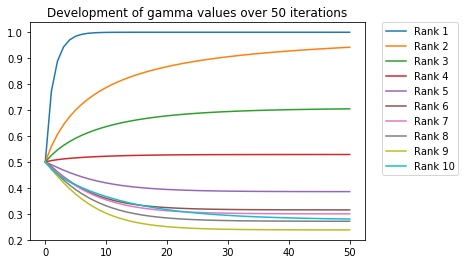

In [91]:
# Analysing the gamma paramter esitmation of PBCM

for i in range(10):
    plt.plot(range(iterations+1), got[i], label="Rank {}".format(i+1))
plt.title("Development of gamma values over {} iterations".format(iterations))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

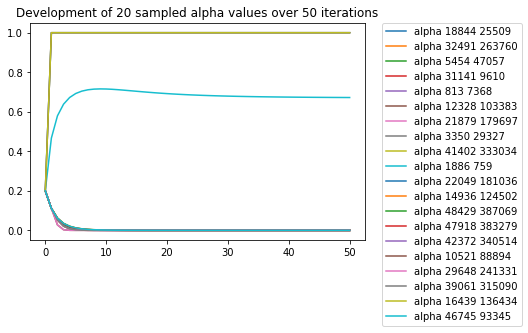

In [10]:
# Analysing the alpha paramter esitmation of PBCM

for alpha, values in aot.items():
    plt.plot(range(iterations+1), values, label="alpha {} {}".format(*alpha))

plt.title("Development of {} sampled alpha values over {} iterations".format(len(aot), iterations))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Step 6: Simulate Interleaving Experiment (10 points)
Having implemented the click models, it is time to run the simulated experiment.

For each of interleaved ranking run N simulations for each one of the click models implemented and measure the proportion p of wins for E.
(Note 7: Some of the models above include an attractiveness parameter 𝑎uq. Use the relevance label to assign this parameter by setting 𝑎uq for a document u in the ranked list accordingly. 

In [11]:
# Step 6 code
# Generic Class to run both the simulations of RandomClickModel and PositionBasedClickModel

class Simulation:
    
    def __init__(self):
        self.interleaved_rankings = []
        self.model = None
        self.ewins = []
        
    def initialize_data(self, simulations, model):
        self.model =  model
        # Get all the pairs of simulations and interleave them and store it in a single list
        for sim in simulations:
            E_ranking, P_ranking = sim
            self.interleaved_rankings.append(team_draft_interleaving(E_ranking, P_ranking))
        
    def start_simulation(self, N):
        for ranking in self.interleaved_rankings:
            relevance, algorithm = zip(*ranking)
            click_probs = self.model.predict_click_prob(algorithm)
            E_wins = 0
            algo_counts = {}
            equals = 0
            # Run N random click sessions and estimate how many times E wins.
            # There are lot of cases where either docs from E and P get the same 
            # number of clicks or both are not clicked at all. We ignore these cases. 
            # In order to be consistent, we consider only cases where either E or P wins
            for i in range(N):
                algo_counts['E'] = 0
                algo_counts['P'] = 0
                wins = self.model.simulate_clicks(click_probs)
                for algorithm, click in wins:
                    if click:
                        algo_counts[algorithm] += 1  
                if algo_counts['E'] > algo_counts['P']:
                    E_wins += 1
                elif algo_counts['E'] == algo_counts['P']:
                    equals += 1
            
            # We store the probaility of E winning in every interleaved simulation. 
            self.ewins.append(E_wins/max(N - equals, 1))

### Step 7: Results and Analysis (30 points)
Compare the results of the offline experiments (i.e. the values of the 𝛥measure) with the results of the online experiment (i.e. proportion of wins), analyze them and reach your conclusions regarding their agreement.


### Method and Hypothesis
In the following sections, we will examine our results from previous questions. 
First of all, we take a look at the different evaluations metrics used and whether their judgements correlate with each other. Afterwards, the percentage of agreement (on whether E wins) between all the metrics is determined.

In order to measure the potential difference between both the online and offline models we will use one-sample one-sided proportion test. In our case this will simply be to record how many times E wins, and divide it by the number of simulations. If E wins significantly more than P, we can assume that the two underlying distributions are statistically different. However, we will simply use this value to compare our different models, and see if they differ in their favor towards either E or P.

Because we have made all possible pairs of rankings, they will be symmetrical, and we therefore expect the E-win proportion to be very close to 0.5, especially with the offline models. In the online models there is a factor of randomness, so we might expect some divergence here, but we still expect the values to be close to 0.5.

In [12]:
# Step 7 code and markdown

from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
    

def one_sample_one_sided_proportion_test(proportion_list):
    # A probability above 0.5 implies a favor for E, thus we count it. Finally we divide by the total
    return len([1 for prop in proportion_list if prop >= 0.5]) / len(proportion_list)

def main_analysis(delta_m_ap, delta_m_ndcg, delta_m_err, rand_model, pos_model):
    # We will use this function to map the values from the delta measures from -1 to 1,
    # to 0 and 1
    def _linear_map(val, A, B, a, b):
        return (val - A)*(b-a)/(B-A) + a 
    
    # Simulate the random clicks
    simul = Simulation()
    simul.initialize_data(simulations, rand_model)
    simul.start_simulation(10)
    e_wins_rand_click = simul.ewins
    
    # Simulate the position based clicks
    simul = Simulation()
    simul.initialize_data(simulations, pos_model)
    simul.start_simulation(10)
    e_wins_pos_based = simul.ewins
    
    # Perform the one-sided-proportion-test for the three offline models, and the two online models
    one_sided_p_ap = one_sample_one_sided_proportion_test(
        list(map(lambda val: _linear_map(val, -1, 1, 0, 1), delta_m_ap)))
    one_sided_p_ndcg = one_sample_one_sided_proportion_test(
        list(map(lambda val: _linear_map(val, -1, 1, 0, 1), delta_m_ndcg)))
    one_sided_p_err = one_sample_one_sided_proportion_test(
        list(map(lambda val: _linear_map(val, -1, 1, 0, 1), delta_m_err)))
    one_sided_p_rand_click = one_sample_one_sided_proportion_test(e_wins_rand_click)
    one_sided_p_pos_based = one_sample_one_sided_proportion_test(e_wins_pos_based)
    
    # Print the results
    print("One sided p sample for one_sided_p_ap", one_sided_p_ap)
    print("One sided p sample for one_sided_p_ndcg", one_sided_p_ndcg)
    print("One sided p sample for one_sided_p_err", one_sided_p_err)
    print("One sided p sample for one_sided_p_rand_click", one_sided_p_rand_click)
    print("One sided p sample for one_sided_p_pos_based", one_sided_p_pos_based)
    
main_analysis(delta_m_ap, delta_m_ndcg, delta_m_err, rand_model, position_model)

One sided p sample for one_sided_p_ap 0.5265965554031398
One sided p sample for one_sided_p_ndcg 0.5055293061694525
One sided p sample for one_sided_p_err 0.5020576131687243
One sided p sample for one_sided_p_rand_click 0.582533150434385
One sided p sample for one_sided_p_pos_based 0.5644972819184068


### Correlation between metrics

In this section, it is examined whether the judgement of our simulations correlates between metrics. Therefore, scatter plots are used, whereby each point represents one simulation with one ranking for P and E respectively. The x- and y-coordinate then stand for a value given by a different metric.

In case two metrics are correlated, we would expect the points to approximate a diagonal from the bottom-left to the top-right corner respectively or from top-left to bottom-right in case of anti-correlation. Also, Pearson's correlation coefficient is computed, whereby a value of $1$ indicates perfect correlation, $-1$ perfect anti-correlation and $0$ no correlation at all.

In [13]:
simul_random = Simulation()
simul_random.initialize_data(simulations, rand_model)
simul_random.start_simulation(100)

simul_position = Simulation()
simul_position.initialize_data(simulations, position_model)
simul_position.start_simulation(100)

judgements = {
    "ndcg": delta_m_ndcg, "err": delta_m_err, "ap": delta_m_ap, "rcm": simul_random.ewins, "pbcm": simul_position.ewins 
}

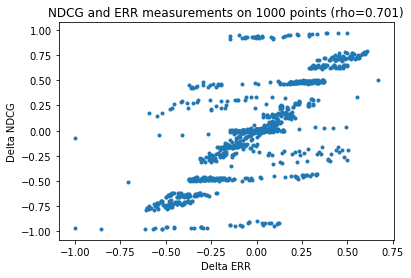

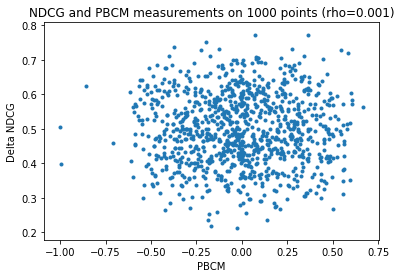

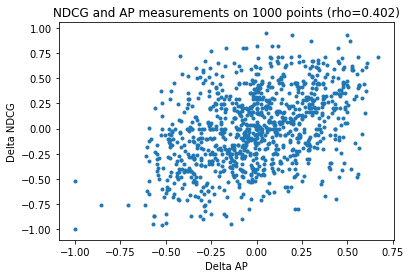

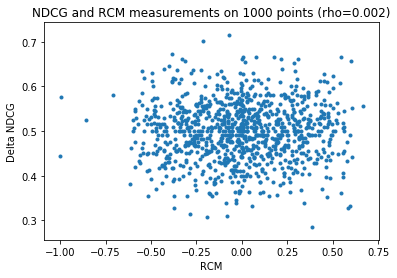

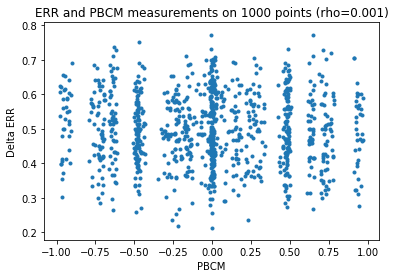

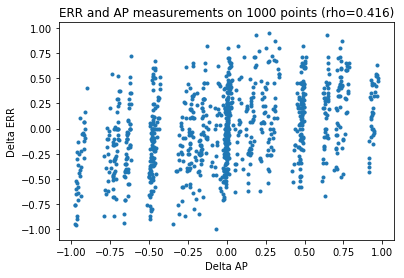

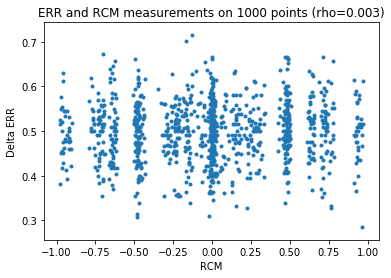

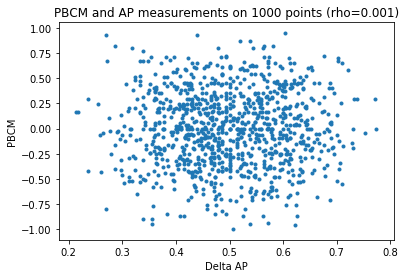

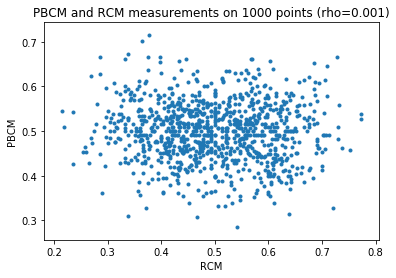

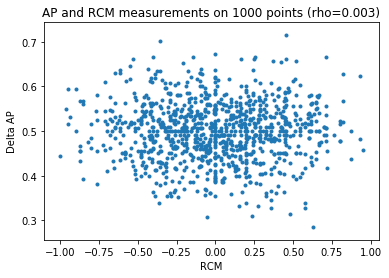

In [14]:
from itertools import combinations
from random import sample
from scipy.stats import pearsonr

sample_size = 1000
sampled_indices = sample(range(len(simul_random.ewins)), sample_size)

for metric1, metric2 in combinations(judgements.keys(), 2):
    metric1_data, metric2_data = judgements[metric1], judgements[metric2]
    
    rho, _ = pearsonr(metric1_data, metric2_data)
    plt.scatter([metric1_data[i] for i in sampled_indices], [metric2_data[i] for i in sampled_indices], marker=".")
    ylabel = "Delta " + metric1.upper() if metric1 in ("ndcg", "err", "ap") else metric1.upper()
    
    xlabel = "Delta " + metric2.upper() if metric2 in ("ndcg", "err", "ap") else metric2.upper()
    plt.title("{} and {} measurements on {} points (rho={:.3f})".format(metric1.upper(), metric2.upper(), sample_size, rho))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
        


As seen in the plot above, only one combination really achieves a significant correlation value: NDGC and ERR with a rho value of 0.701.

For every other model, the lack of correlation is surprising but could be explained by the following thoughts:
* Online and offline evaluation measures differ greatly in their approach, as the first tries to estimate model parameters from real user data, where as offline measures make more or less arbitrary assumptions about user click behaviour.
* The reason only NDCG and ERR seem to be slightly correlated could be that they determine their measurement by considering all the rank in a ranking, whereas AP only considers ranks with a certain relevance labels, explaining why the combinations AP - NDCG and AP - ERR have a smaller rho value of around 0.4.
* Generally speaking, all the models make strong assumptions about the user behaviour. It is therefore not too surprising that we got the results seen above.

### Significance Testing

As mentioned above we expected the different p-values to be close to 0.5. The final time we ran the code we got the following results:

* One sided p sample for Average precision 0.5265965554031398
* One sided p sample for NDCG 0.5055293061694525
* One sided p sample for ERR 0.5020576131687243
* One sided p sample for Random Click Model 0.582533150434385
* One sided p sample for Position Based Model 0.5644972819184068

As we can see the three offline models are very close to the expected 0.5. This implies that the results are not significant, which was expected. This is because if we have the ranking P: (N, N, N) E: (R, R, R), E will probably win, but we will also have the reverse result, giving P a win. 

The online models favor E a bit more

### Conclusion

[TODO]